# ***Dataset Thresholding***

This notebook shows the thresholding of the dataset. We apply thresholding
to an MSI in order to separate tissue spectra's from all spectra's.

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import os
import numpy as np
from skimage import filters
from skimage.morphology import disk
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
from typing import Tuple
from pathlib import Path

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../DHG/"
# Define folder that contains the preprocessed dataset
PREPROCESSED_PATH = f"{DHG_PATH}/preprocessed"
# Define path to save plots
PLOTS_PATH = "./../plots_and_their_data/thresholding"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define representative peaks 
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]

### ***Creating output folder***

Next, let's create the output folder:

In [3]:
# Create output folder if doesn't exist
Path(PLOTS_PATH).mkdir(parents=True, exist_ok=True)

### ***Define function to try all treshould methods***

Next, let's define a function to try all treshould methods on given image:

In [4]:
def try_all_threshold(
    img: np.ndarray, figsize: Tuple[int, int]
) -> Tuple[plt.Figure, np.ndarray]:
  """ Function to return a figure comparing the outputs of different
  thresholding methods.
  
  Args:
    img (np.ndarray): Grayscale input image.
    figsize (Tuple[int, int]): Figure size (in inches).
    
  Returns:
    [Tuple[plt.Figure, np.ndarray]]: Matplotlib figure and axes.
  
  """
  # create subplot
  fig, axes = plt.subplots(ncols=9, sharex=True, sharey=True, figsize=figsize)

  img = filters.gaussian(img, sigma=0.5)

  # add each subplot
  axes[0].imshow(img, cmap='viridis')
  axes[0].set_title('Original', fontsize=16)

  axes[1].imshow(img > filters.threshold_isodata(img), cmap=plt.cm.gray)
  axes[1].set_title('Isodata', fontsize=16)

  axes[2].imshow(img > filters.threshold_li(img), cmap=plt.cm.gray)
  axes[2].set_title('Li', fontsize=16)

  axes[3].imshow(img > filters.threshold_mean(img), cmap=plt.cm.gray)
  axes[3].set_title('Mean', fontsize=16)

  axes[4].imshow(img > filters.threshold_minimum(img), cmap=plt.cm.gray)
  axes[4].set_title('Minimum', fontsize=16)

  axes[5].imshow(img > np.median(img), cmap=plt.cm.gray)
  axes[5].set_title('Median', fontsize=16)

  axes[6].imshow(img > filters.threshold_otsu(img), cmap=plt.cm.gray)
  axes[6].set_title('Otsu', fontsize=16)

  axes[7].imshow(img > filters.threshold_triangle(img), cmap=plt.cm.gray)
  axes[7].set_title('Triangle', fontsize=16)

  axes[8].imshow(img > filters.threshold_yen(img), cmap=plt.cm.gray)
  axes[8].set_title('Yen', fontsize=16)

  # remove axis from each subplot
  for ax in axes:
    ax.axis('off')

  # return plot
  return fig, axes

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Get all MSI names:***

Next, let's get all the MSI names from dataset path:

In [6]:
# Get all MSI names
msi_names = np.asarray(
    [f for f in os.listdir(PREPROCESSED_PATH) if f.endswith(".imzML")])

### ***Trehsould each MSI:***

Next, let's treshould each MSI to see what technique is best:

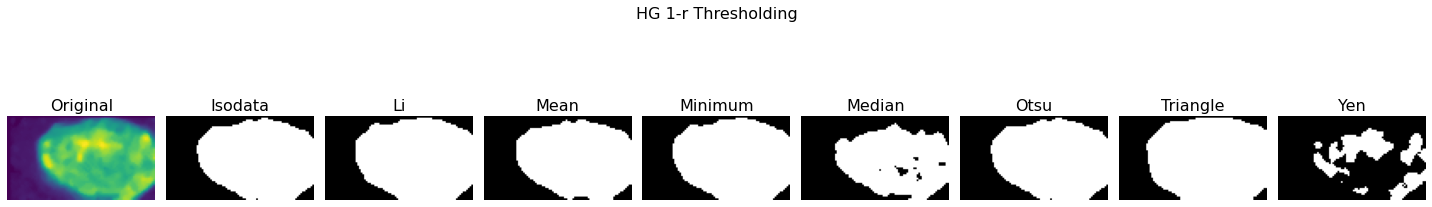

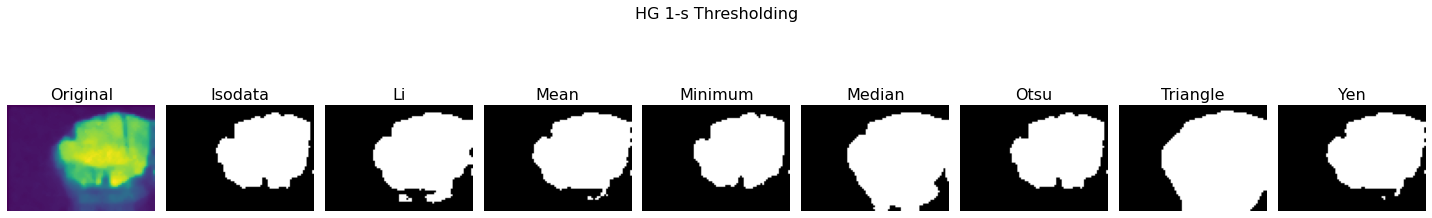

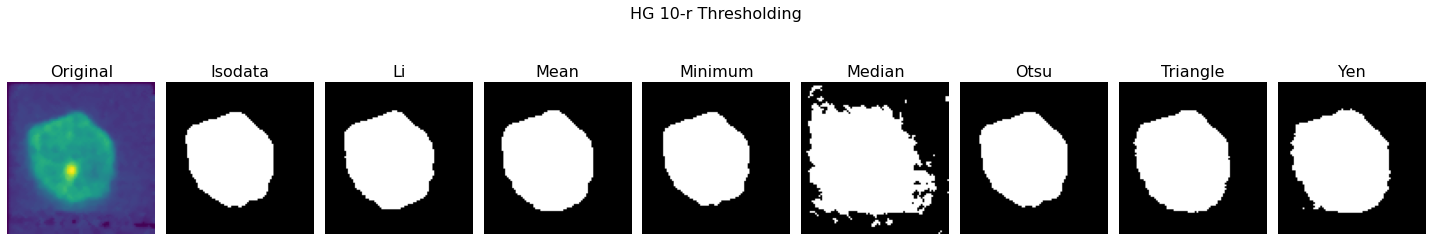

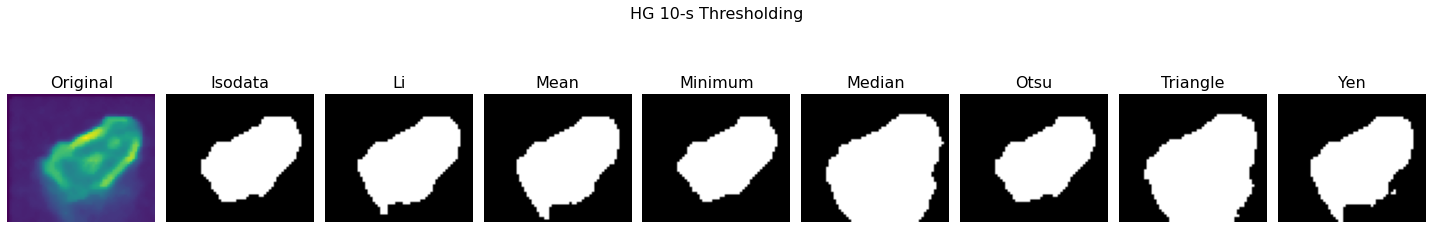

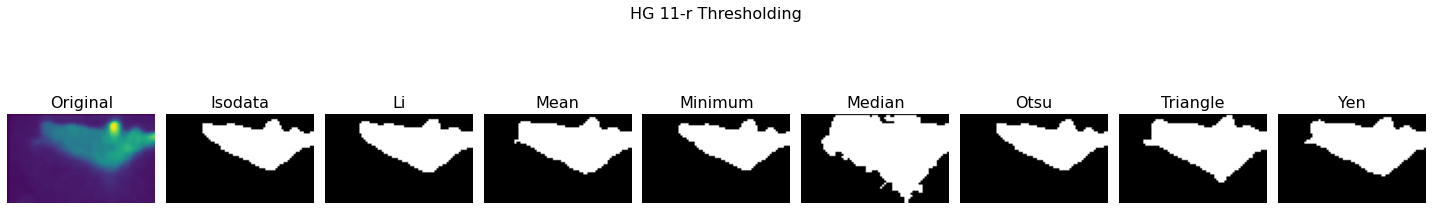

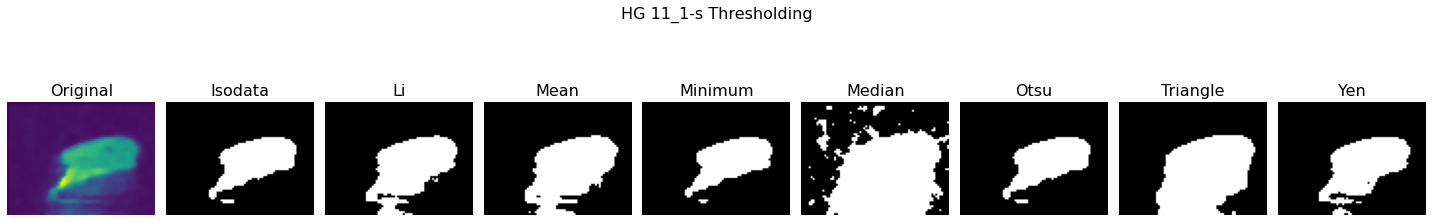

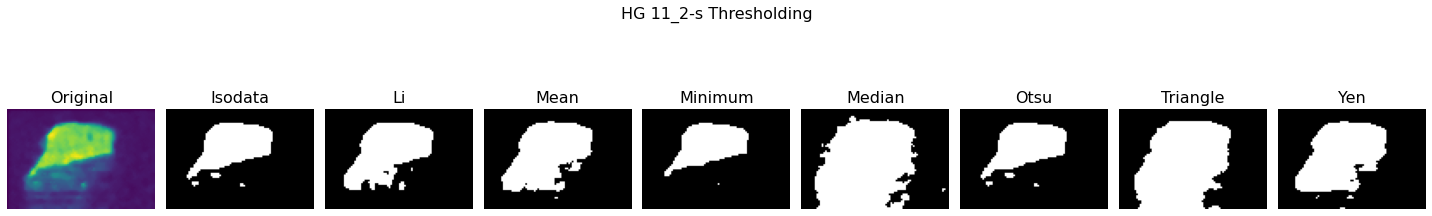

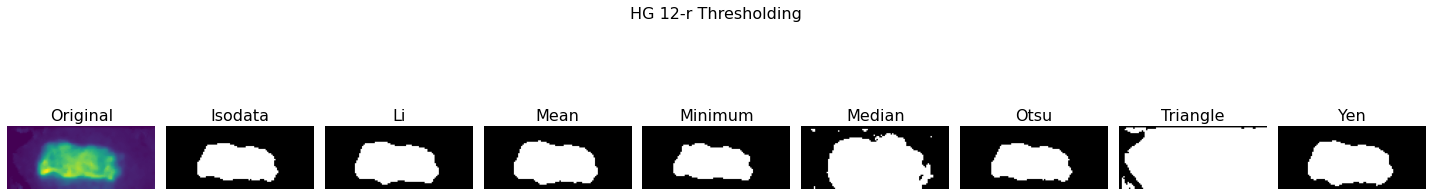

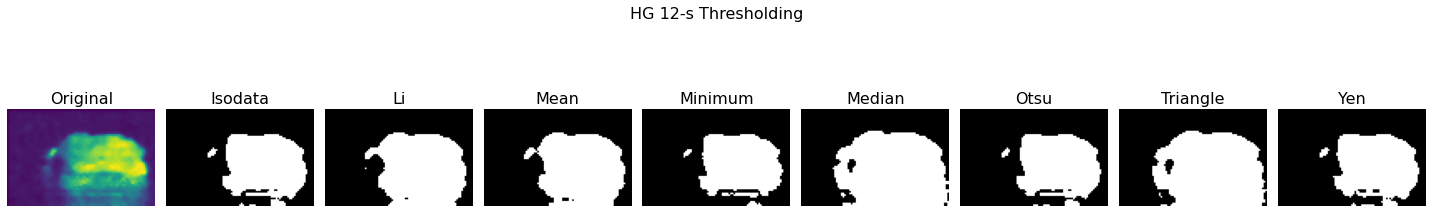

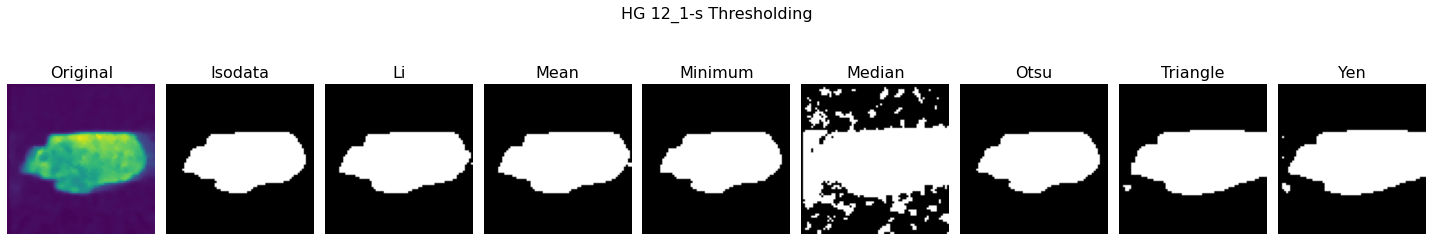

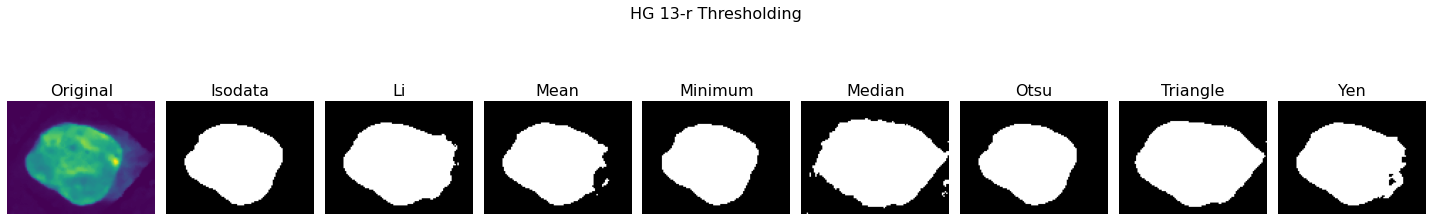

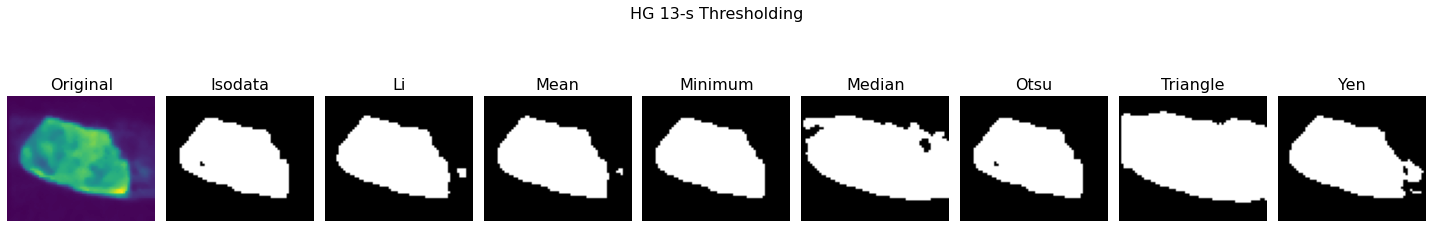

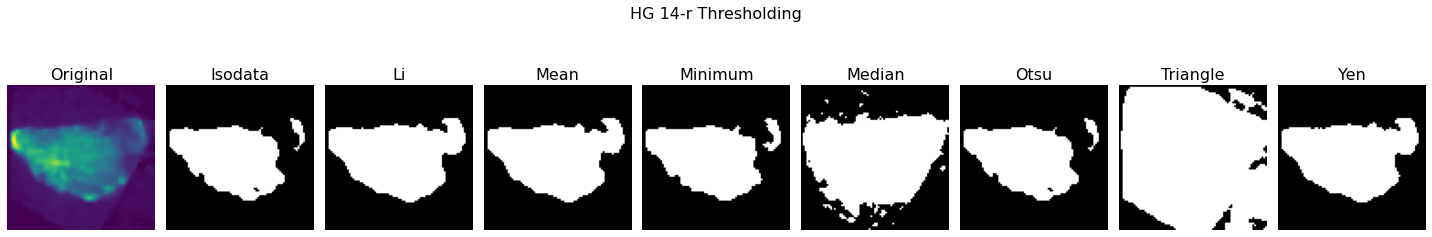

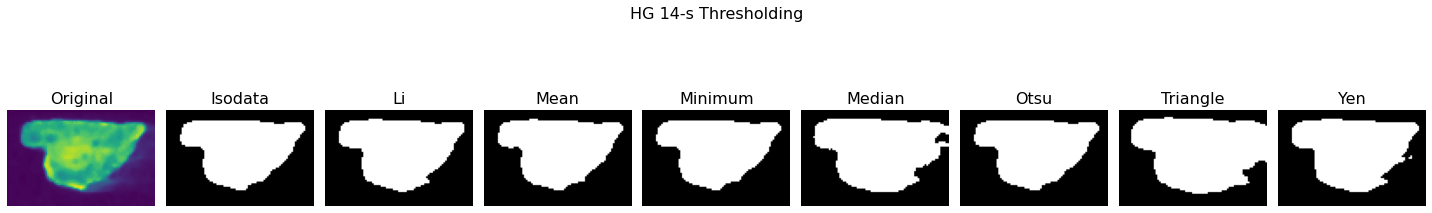

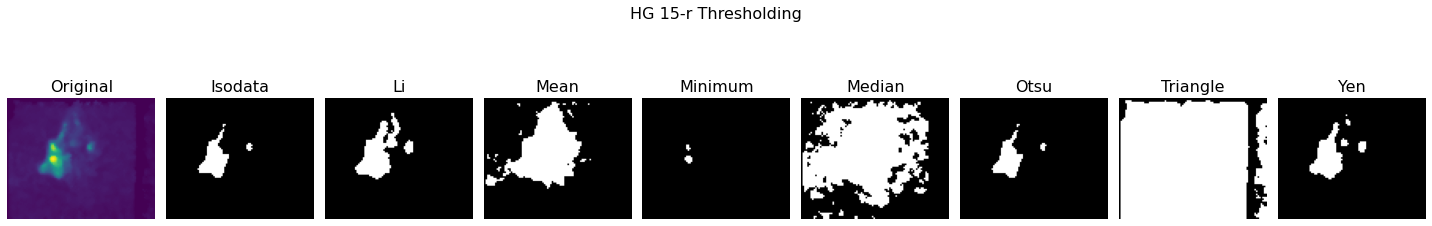

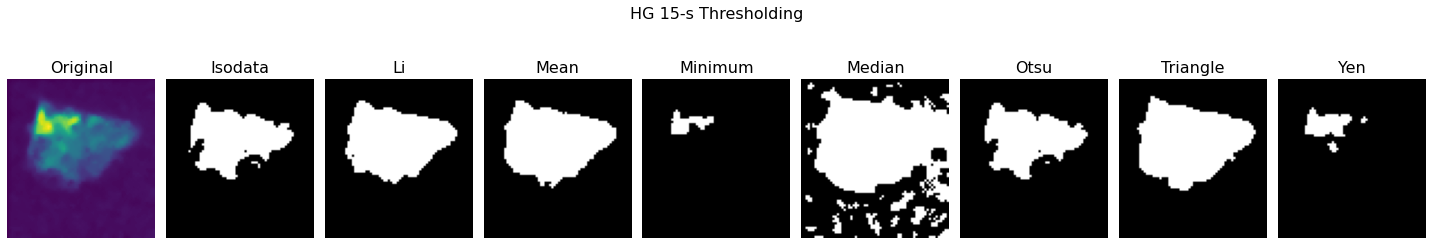

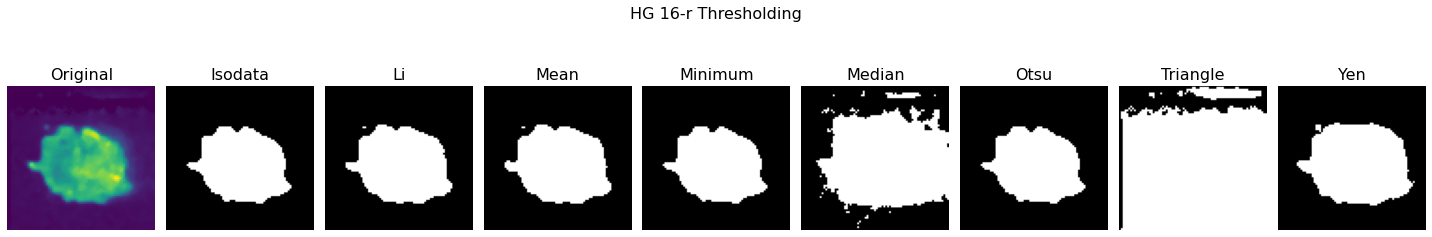

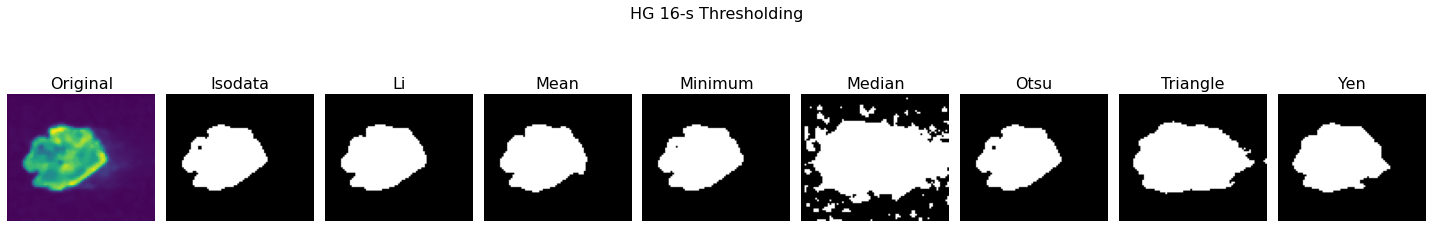

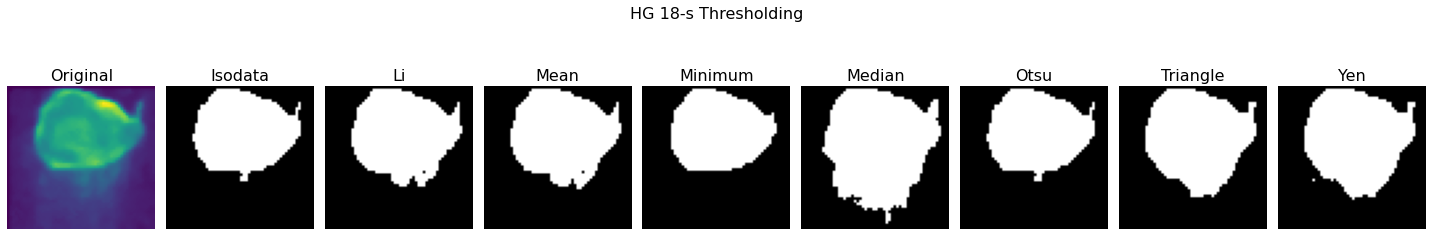

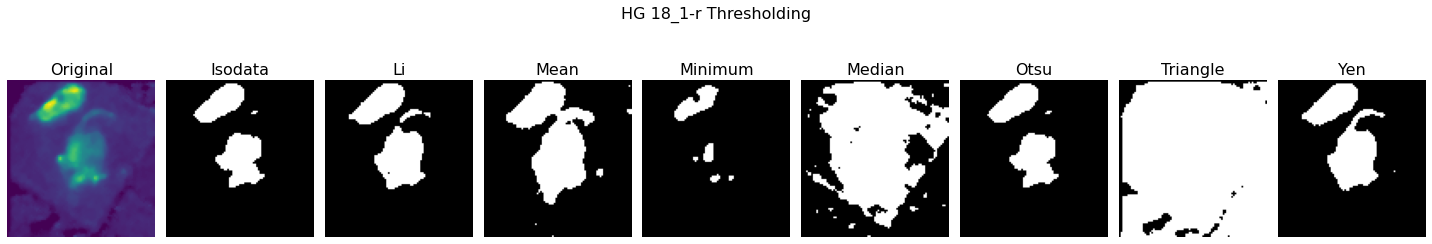

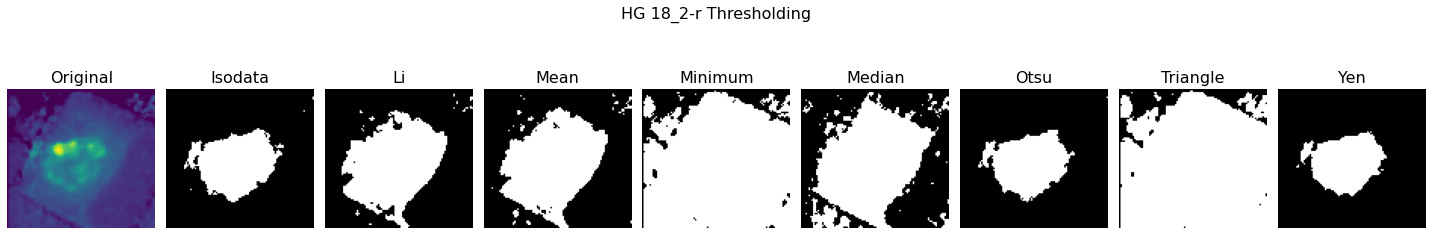

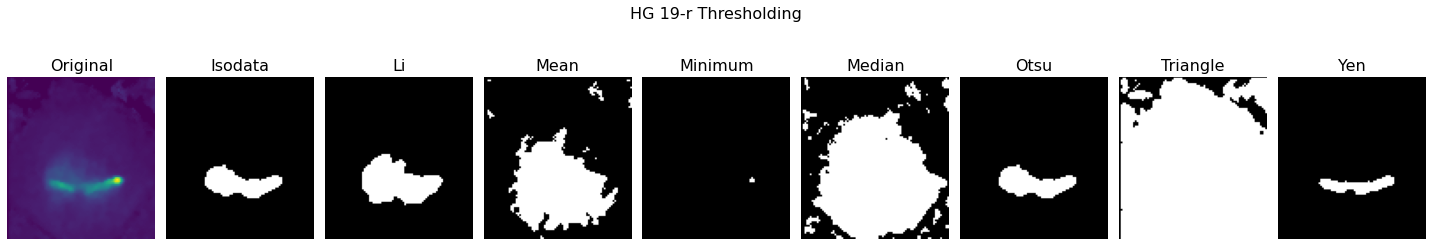

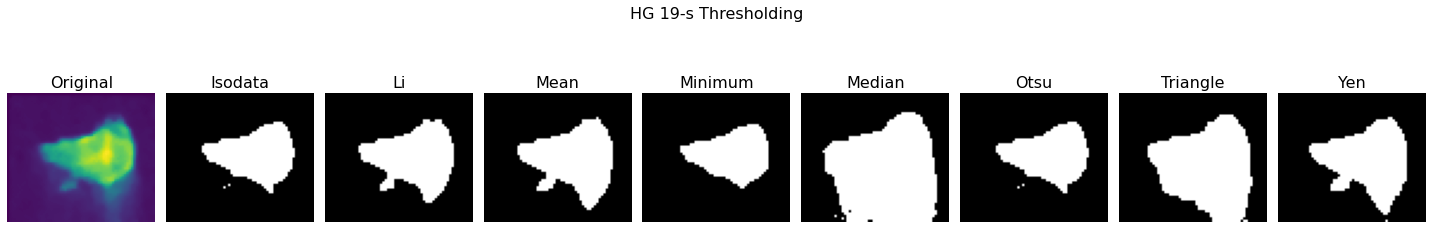

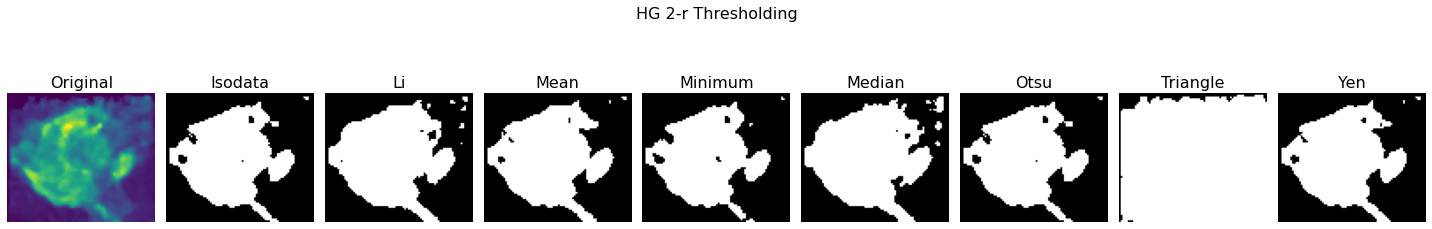

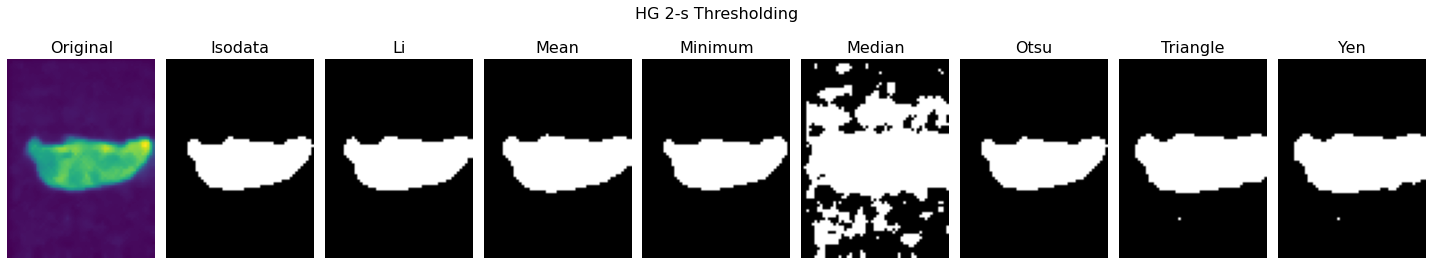

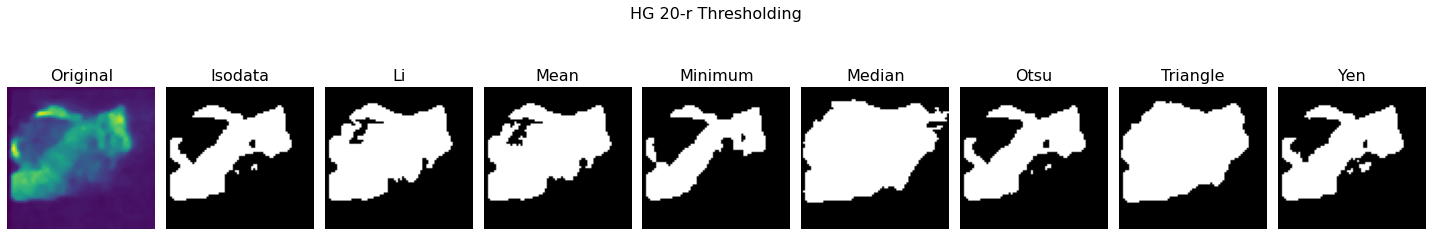

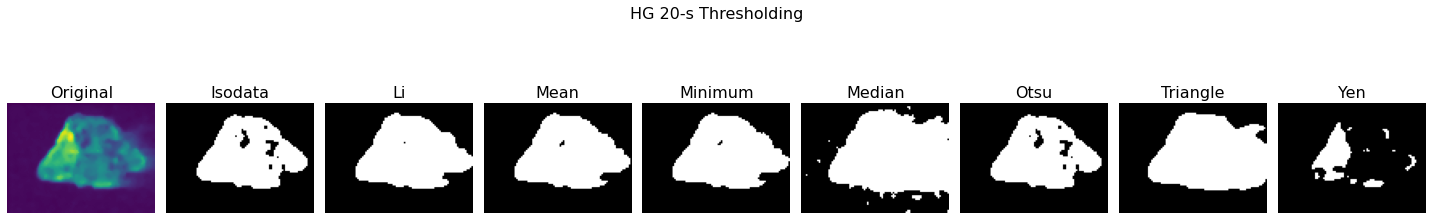

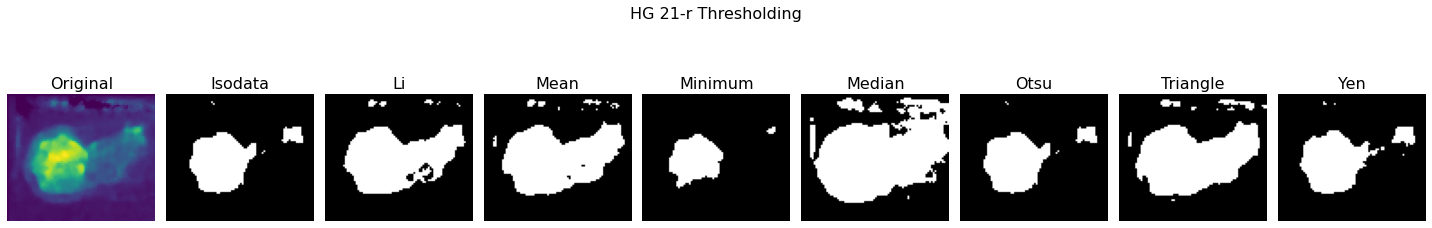

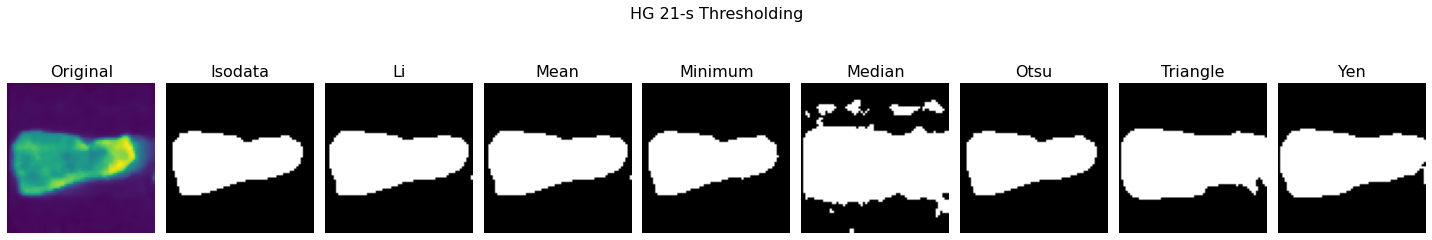

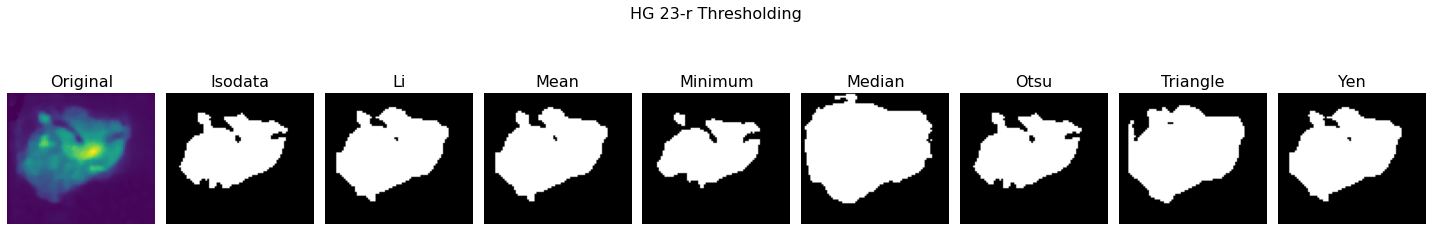

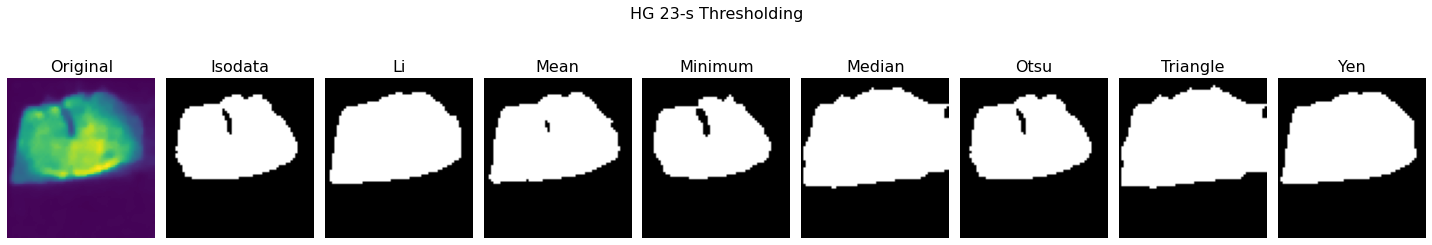

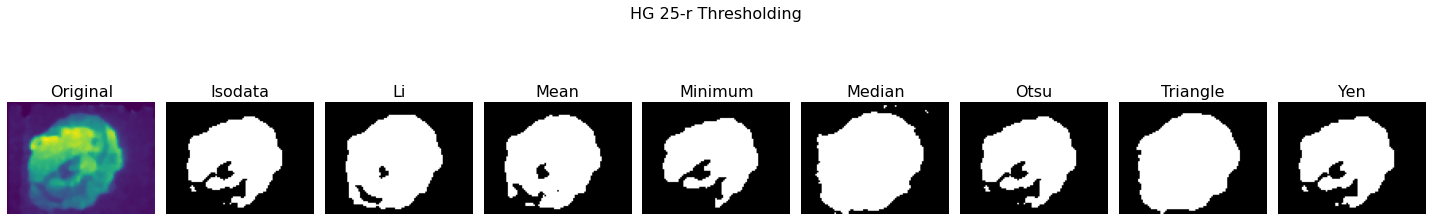

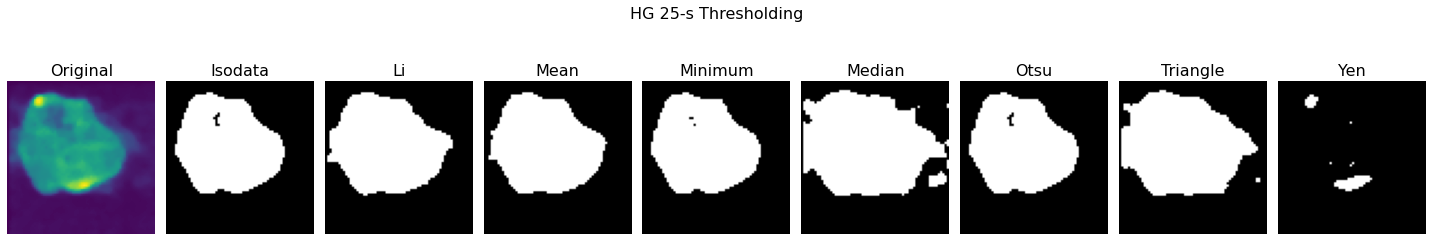

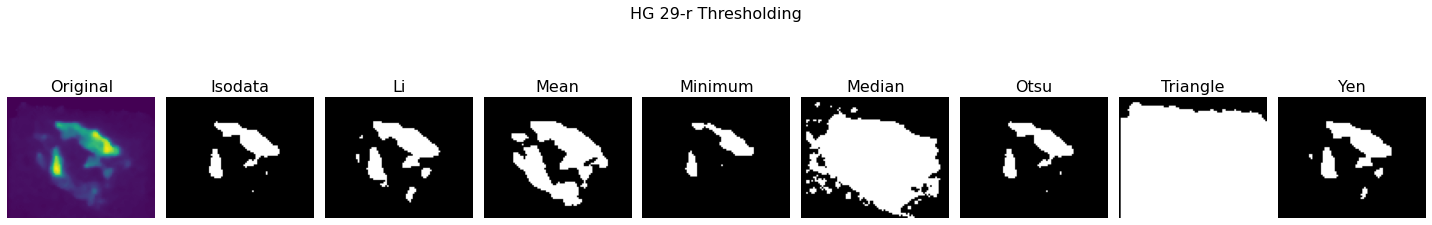

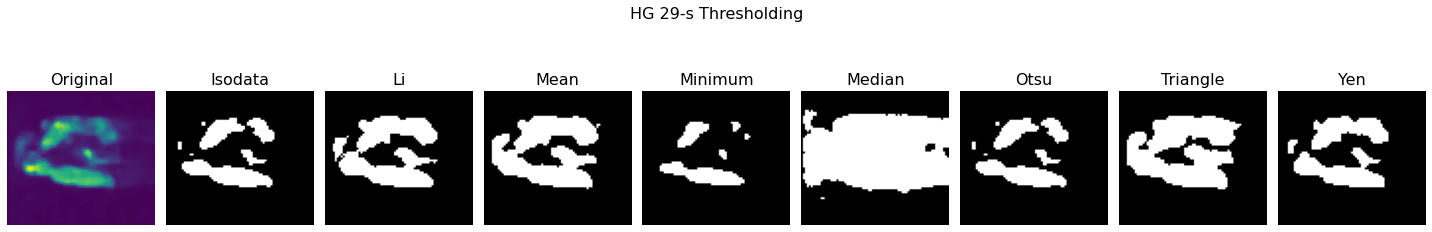

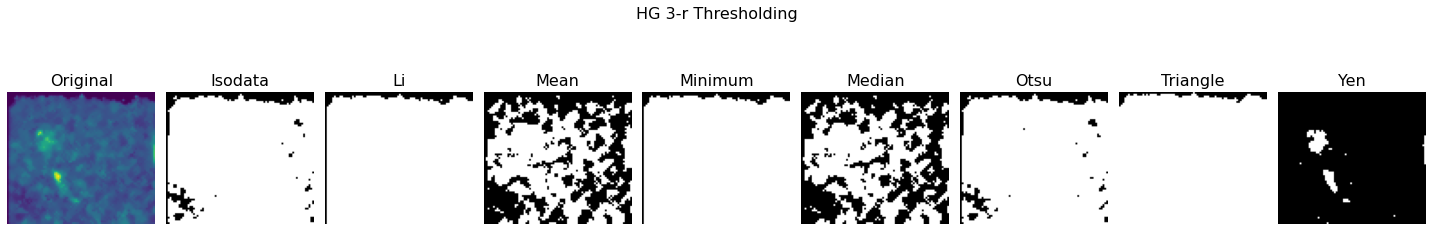

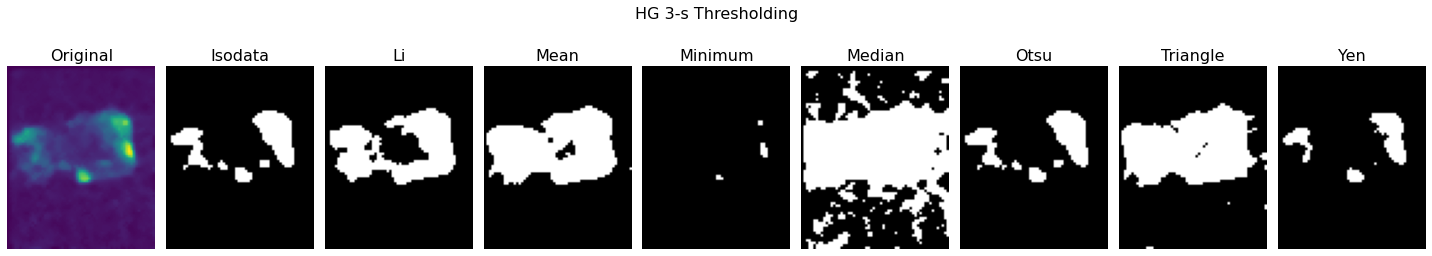

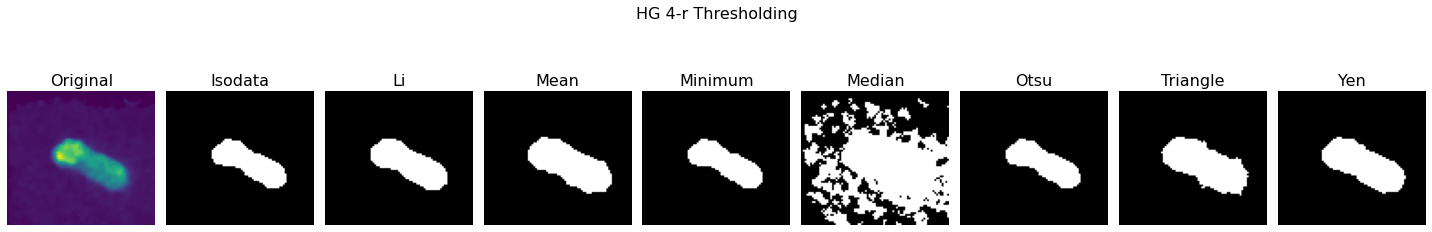

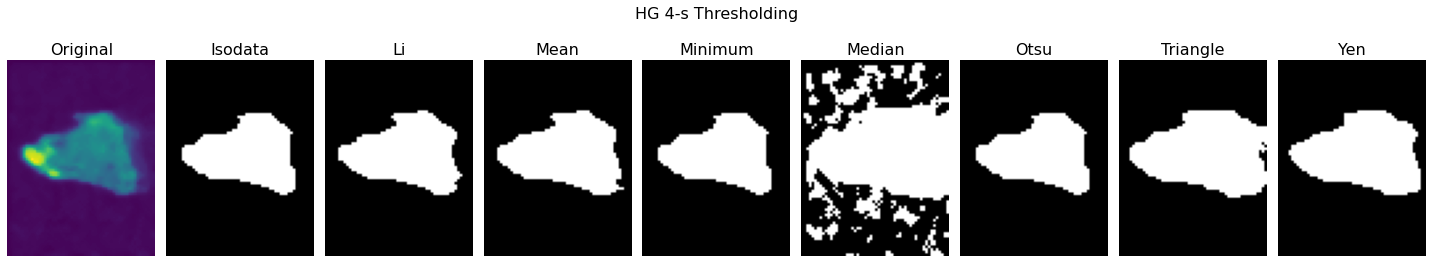

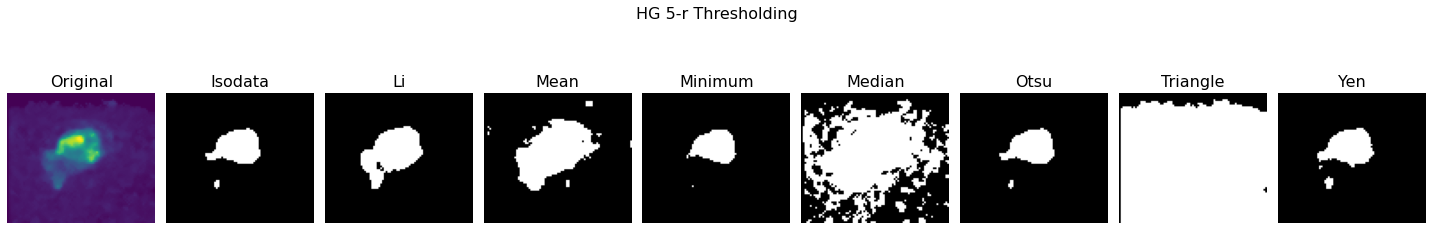

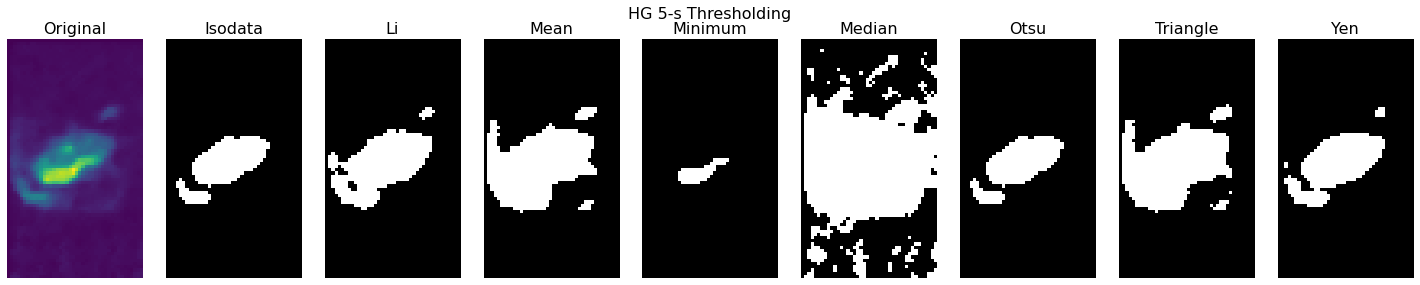

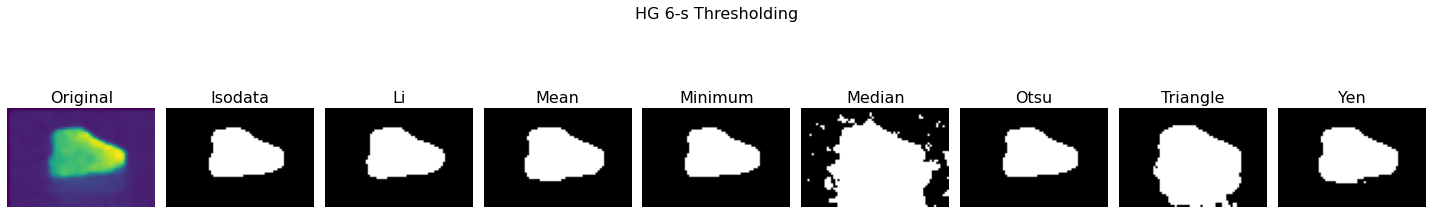

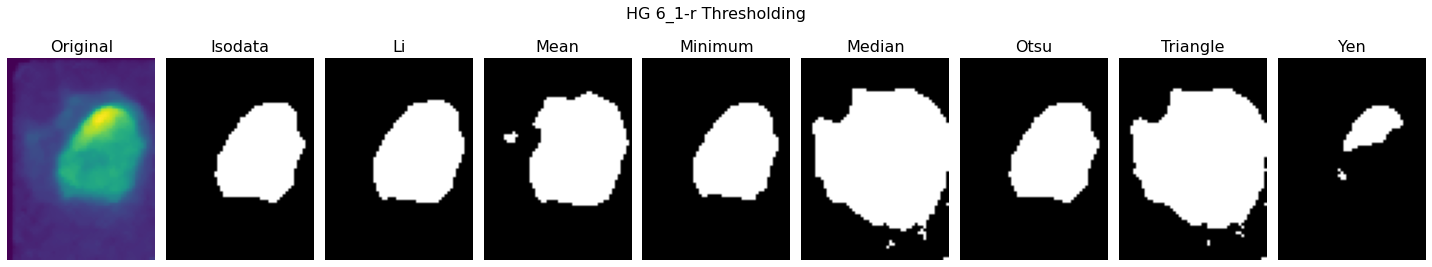

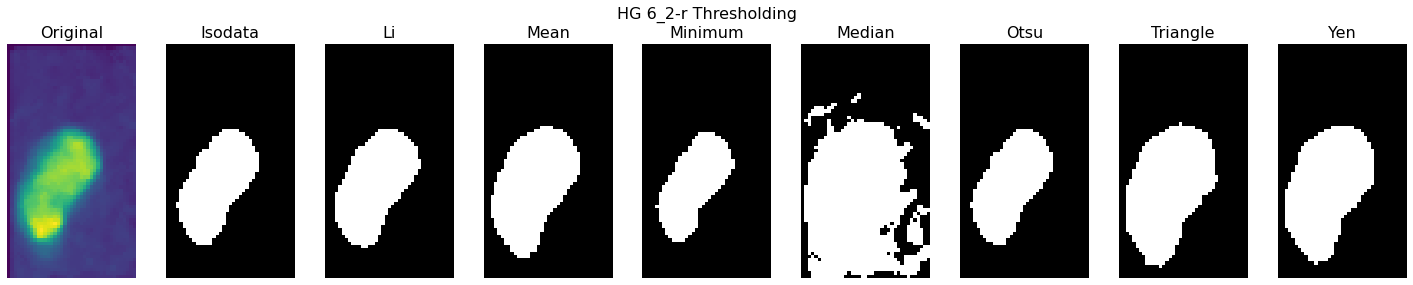

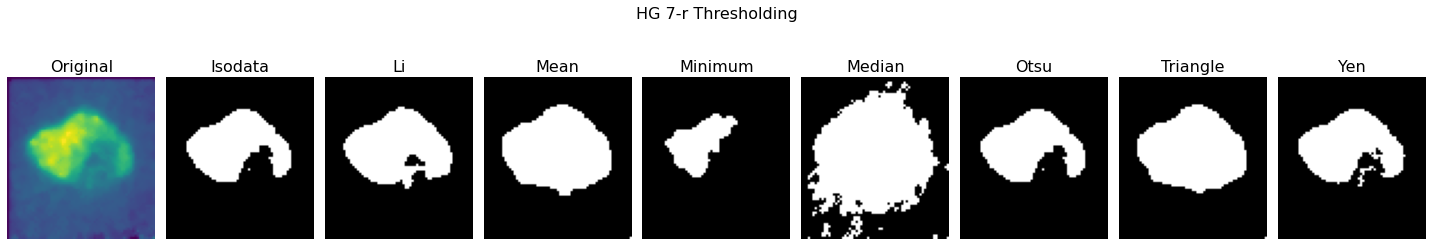

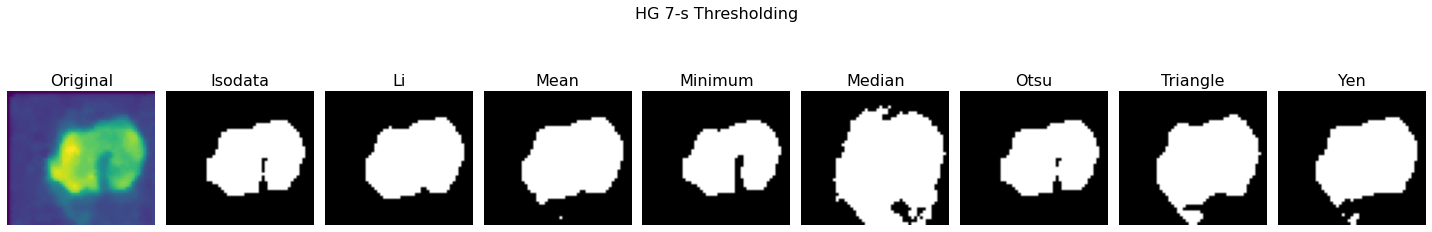

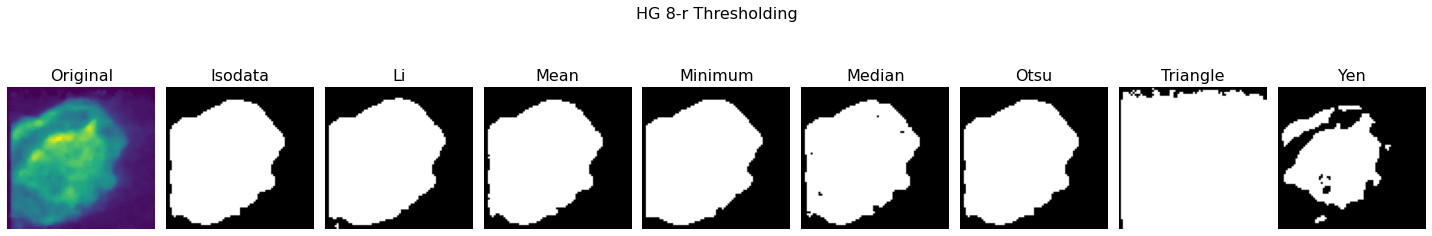

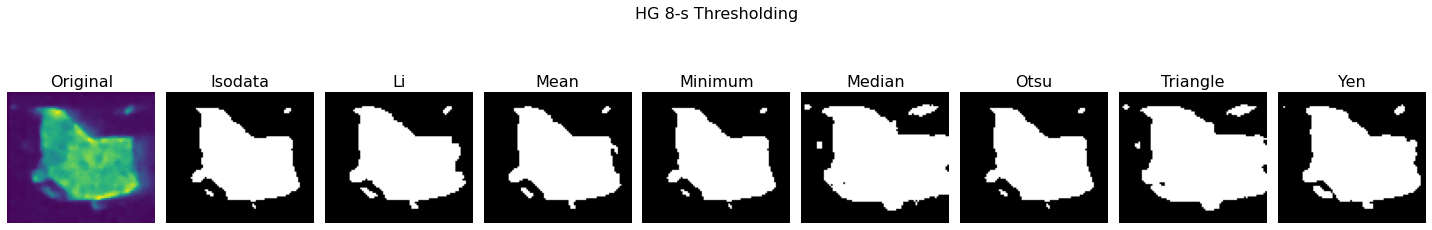

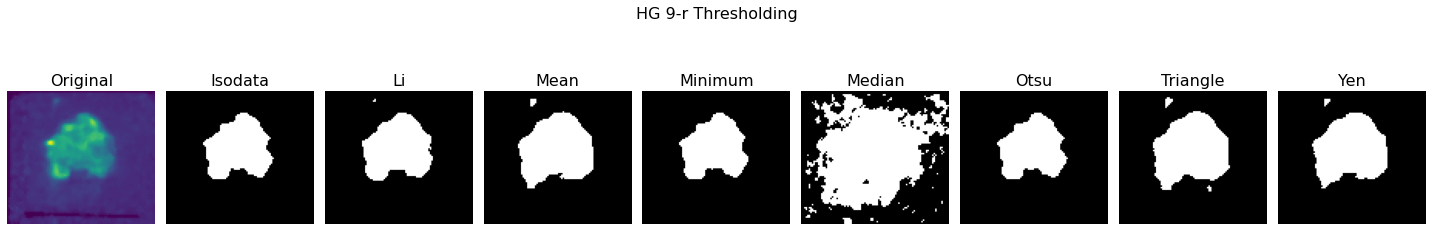

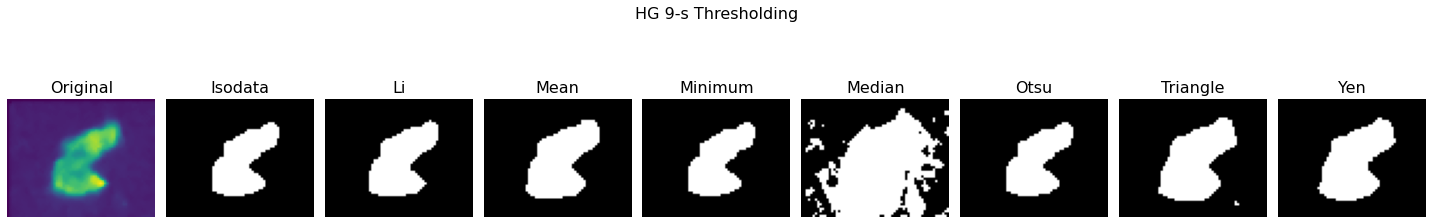

In [7]:
# Loop over each MSI name
for msi_name in msi_names:
  # Parse the MSI file
  with ImzMLParser(os.path.join(PREPROCESSED_PATH, msi_name)) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Define filter of representative peaks
    filter_all = False
    for peak in REPRESENTATIVE_PEAKS:
      filter_all |= (mzs >=
                     peak - MASS_RESOLUTION) & (mzs <= peak + MASS_RESOLUTION)
    
    # Get representative peaks accumulative image
    representative_peaks_img = data[:, :, filter_all].sum(axis=-1)

    # Remove salt and pepper noise
    smooth = filters.median(representative_peaks_img, disk(2))

    # Get all thresholding algorithms outputs
    fig, ax = try_all_threshold(smooth, figsize=(20, 4))

    # plot thresholding algorithms outputs
    fig.suptitle(f"{msi_name.split('.')[0]} Thresholding", fontsize=16)
    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_PATH}/{msi_name.split('.')[0]}_thresholding.png",
        transparent=True
    )
    plt.show()

    # Save data for plot creation
    np.savetxt(
        f"{PLOTS_PATH}/{msi_name.replace('.imzML', '')}_local_tic.csv",
        representative_peaks_img, delimiter=","
    )